In [1]:
%matplotlib inline
import matplotlib.pyplot as plt; import seaborn as sns; import numpy as np; import xarray as xr
import os;  from pathlib import Path; import pandas as pd


import cartopy.crs as ccrs; import cartopy.feature as cfeature
# import cftime

import sys; import subprocess
sys.path.append('/rds/homes/d/duttaay/pyfuncs')
from pyutil import *

[1724885980.261636] [bear-pg0203u17a:1570381:0]        ib_iface.c:1034 UCX  ERROR ibv_create_cq(cqe=4096) failed: Cannot allocate memory


[bear-pg0203u17a.bear.cluster:1570381] pml_ucx.c:309  Error: Failed to create UCP worker


In [2]:
ds = xr.open_dataset('/rds/homes/d/duttaay/geenr-bridge-monsoon/data/HadISST_sst.nc')
ds = ds.rename(dict(longitude='lon',latitude='lat'))

sst = ds.sst 
sst = xr.where(sst<-15,np.nan,sst)
sst = sst + 273

In [3]:
sst_ = sst.sel(lon=slice(-80,10),lat=slice(0,70,-1))

def amo_(da):

    sst_clim = da.groupby("time.month").mean("time")
    sst_anomaly = da.groupby("time.month") - sst_clim
    sst_jjas = sst_anomaly.sel(time=sst_anomaly.time.dt.month.isin([6,7,8,9])).groupby('time.year').mean()
    sst_jjas = year_to_time(sst_jjas)
    
    sstna = sst_jjas.sel(lon=slice(-80,0),lat=slice(0,70,-1))
    sstg = sst_jjas.sel(lat=slice(-60,60,-1))
    ssta_av = wgt_areaave(sstna,weighted=True)
    ssta_gav = wgt_areaave(sstg,weighted=True)
    ssta_na = ssta_av - ssta_gav


    # amor = rolling_avg(ssta_dt,weights_lp,window)
    amor = ssta_na.rolling(time=11, center=True).mean('time').dropna('time',how='all')
    amo = (amor - amor.mean('time'))/amor.std('time')    

    return amo

amo = amo_(sst)

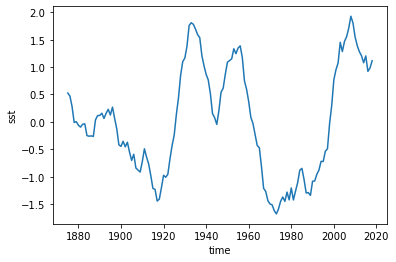

In [4]:
amo.plot()

In [5]:
sst_clim = sst.groupby("time.month").mean("time")
sst_anomaly = sst.groupby("time.month") - sst_clim

# sst_dt = detrend_dim(sst_anomaly,dim='time')
# sst_anomaly = sst_dt

sstg = sst_anomaly.sel(lat=slice(-60,60,-1))
ssta_gav = wgt_areaave(sstg,weighted=True)
sst_anomaly = sst_anomaly - ssta_gav


sst_jjas = sst_anomaly.sel(time=sst_anomaly.time.dt.month.isin([6,7,8,9])).groupby('time.year').mean()
sst_jjas = year_to_time(sst_jjas)

In [6]:
sst_lp = sst_jjas.rolling(time=11, center=True).mean('time').dropna('time',how='all')
# sst_lp[0].plot()

In [7]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(amo,sst_lp)

/rds/bear-apps/2021b/EL8-ice/software/xarray/0.20.1-foss-2021b/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [8]:
# slope.plot()

In [9]:
slope

<xarray.DataArray 'sst' (lat: 180, lon: 360)>
array([[-0.11495303, -0.11617086, -0.11579583, ..., -0.11480717,
        -0.11481378, -0.11482204],
       [-0.06572671, -0.06570072, -0.06567969, ..., -0.06548275,
        -0.06526684, -0.06550267],
       [-0.06466048, -0.06563706, -0.065671  , ..., -0.06482312,
        -0.06557625, -0.06457399],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

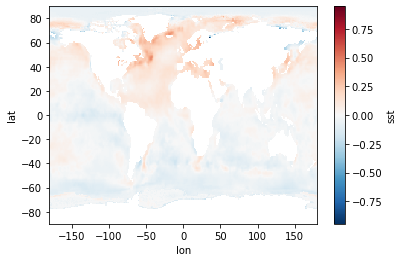

In [10]:
slope.plot()

In [11]:
ds_isca = xr.open_dataset('/rds/homes/d/duttaay/bridge/model/Isca/exp/test_cases/realistic_continents/input/sst_clim_amip.nc',
                         decode_times=False)
time = ds_isca['time']
ds_isca['time'] = pd.date_range('01-01-2024','12-31-2024',freq='M')
# units, reference_date = ds_isca.time.attrs['units'].split('since')
# ds_isca['time'] = pd.date_range(start=reference_date, periods=ds.sizes['time'], freq='M')
ds_isca.sst_clim_amip[0]

<xarray.DataArray 'sst_clim_amip' (lat: 180, lon: 360)>
array([[271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597],
       [271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597],
       [271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597],
       ...,
       [271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597],
       [271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597],
       [271.3597, 271.3597, 271.3597, ..., 271.3597, 271.3597, 271.3597]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    time     datetime64[ns] 2024-01-31

## add_and_regrid_sst_anomaly_to_isca_grid

In [12]:
cov,cor,slope,intercept,pval,stderr = lag_linregress_3D(amo,sst_lp)

# to increase signal-to-noise ratio in the reponse
slope *= 2 

slope.coords['lon'] = (slope.coords['lon']) % 360 
slope = slope.sortby(slope.lon)


# open isca_sst
ds_isca = xr.open_dataset('/rds/homes/d/duttaay/bridge/model/Isca/exp/test_cases/realistic_continents/input/sst_clim_amip.nc',decode_times=False)
ds_isca['time'] = pd.date_range('01-01-2024','12-31-2024',freq='M')

# interpolate to isca_grid
slope = slope.interp_like(ds_isca.sst_clim_amip[0])


# add anomaly over north Atlantic
condn = ((slope.lat >= 0) & (slope.lat <= 70)) & ((slope.lon >= 280) & (slope.lon <= 360))
anom = slope.where(condn,0)
anom = ds_isca.sst_clim_amip + anom

# fill land values with isca_sst_data
anom = xr.where(np.isnan(anom),ds_isca.sst_clim_amip,anom)

/rds/bear-apps/2021b/EL8-ice/software/xarray/0.20.1-foss-2021b/lib/python3.9/site-packages/xarray/core/computation.py:733: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


In [13]:
ds_isca = xr.open_dataset('/rds/homes/d/duttaay/bridge/model/Isca/exp/test_cases/realistic_continents/input/sst_clim_amip.nc',
                         decode_times=False)
time = ds_isca['time']
ds_isca['time'] = pd.date_range('01-01-2024','12-31-2024',freq='M')

ds_anom = ds_isca.copy()
ds_anom['sst'] = anom.astype('float32')
ds_anom = ds_anom.drop('sst_clim_amip')
ds_anom = ds_anom.rename(dict(sst='sst_clim_amip'))
ds_anom['time'] = time


In [21]:
ds_isca = xr.open_dataset('/rds/homes/d/duttaay/bridge/model/Isca/exp/test_cases/realistic_continents/input/sst_clim_amip.nc',
                         decode_times=False)
time = ds_isca['time']
ds_isca['time'] = pd.date_range('01-01-2024','12-31-2024',freq='M')

ds_anom = ds_isca.copy()
ds_anom['sst_clim_amip'] = anom.astype('float32')
ds_anom['time'] = time


ds_anom = ds_anom.rename(dict(sst_clim_amip='sst_clim_plus_amo_ssta'))
ds_anom

<xarray.Dataset>
Dimensions:                 (lat: 180, lon: 360, latb: 181, lonb: 361, time: 12)
Coordinates:
  * lat                     (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                     (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * latb                    (latb) float64 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
  * lonb                    (lonb) float64 0.0 1.0 2.0 3.0 ... 358.0 359.0 360.0
  * time                    (time) float64 15.0 45.0 75.0 ... 285.0 315.0 345.0
Data variables:
    sst_clim_plus_amo_ssta  (time, lat, lon) float32 271.4 271.4 ... 271.4 271.4

In [23]:


# ds_anom.time.attrs['calendar_axis'] = 'T'
ds_anom.time.attrs['units'] = "days since 0000-01-01 00:00:00.0"
# ds_anom.time.attrs['calendar'] = "THIRTY_DAY_MONTHS"
ds_anom.time.attrs['calendar_type'] = "THIRTY_DAY_MONTHS"

ds_anom['lat'] = ds_isca['lat']
ds_anom['lon'] = ds_isca['lon']
ds_anom['lonb'] = ds_isca['lonb']
ds_anom['latb'] = ds_isca['latb']


# xx = ds_anom.sst_clim_amip[0]-ds_isca.sst_clim_amip[0]
# xx.plot()

ofile = '/rds/homes/d/duttaay/bridge/model/Isca/exp/test_cases/realistic_continents/input/sst_clim_plus_amo_ssta.nc'
os.system('rm -rf ' + ofile)
ds_anom.to_netcdf(ofile,format='NETCDF3_CLASSIC',
                 
                unlimited_dims=['time'],
                 encoding={"sst_clim_plus_amo_ssta": {"dtype": "float32",'_FillValue': None},
                           
                           "lat": {"dtype": "double",'_FillValue': None},
                           "lon": {"dtype": "double",'_FillValue': None},
                           "time": {"dtype": "double",'_FillValue': None},

                           "latb": {"dtype": "double",'_FillValue': None},
                           "lonb": {"dtype": "double",'_FillValue': None},
                           
                            }
                 
                 )

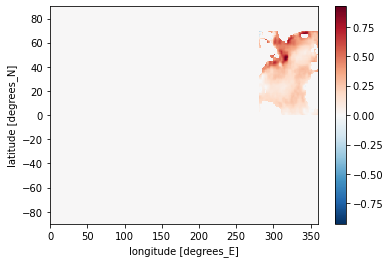

In [24]:
xx = ds_anom.sst_clim_plus_amo_ssta[0]-ds_isca.sst_clim_amip[0]
xx.plot()